# Quantum state tomography (QST) with LS

In [54]:
# To call the libraries for the GD-QST
import sys
sys.path.insert(0, '..')
# You have to change the path of the library

from qutip import * 
from itertools import *
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
#from qutip import basis, tensor

from qst_tec.least_square import least_square_qst
from qst_tec.compressed_sensing import compressed_sensing_qst
from qst_tec.convex_optimization_cvx import cvx_qst


### First we will define the number of qudits, the dimension d, and the measurement operators. We will use the Gell-mann matrices.


In [55]:
number_qudits: int = 2
dims_qudits: int = 4
dimension: int = dims_qudits**number_qudits
HS: int = dimension

# Creating the Measurement operators (Pauli matrices)

# computation basis, important for the other methods
def qubit_computation_basis(n,d):
    basis_states = [basis(d, i) for i in range(d)]
    return [tensor(*state) for state in product(basis_states, repeat=n)]

computation_basis = qubit_computation_basis(number_qudits, dims_qudits)

operator_basis = [Qobj(tensor(computation_basis[i],computation_basis[j].dag()), 
                dims=([[dimension], [dimension]])) for i in range(len(computation_basis)) for j in range(len(computation_basis))]


def gellmann_matrices(d):
    matrices = []

    # Off-diagonal symmetric matrices: E_ij + E_ji, for 0 <= i < j < d
    for i in range(d):
        for j in range(i+1, d):
            mat = np.zeros((d, d), dtype=complex)
            mat[i, j] = 1
            mat[j, i] = 1
            matrices.append(mat)

    # Off-diagonal antisymmetric matrices: -i(E_ij - E_ji)
    for i in range(d):
        for j in range(i+1, d):
            mat = np.zeros((d, d), dtype=complex)
            mat[i, j] = -1j
            mat[j, i] = 1j
            matrices.append(mat)

    # Diagonal matrices
    for k in range(1, d):
        mat = np.zeros((d, d), dtype=complex)
        coeff = np.sqrt(2 / (k * (k + 1)))
        for i in range(k):
            mat[i, i] = 1
        mat[k, k] = -k
        matrices.append(coeff * mat)

    return matrices

identity_op = qeye(dims_qudits)
gellmann = [identity_op]+gellmann_matrices(dims_qudits)
gellmann_objs = [Qobj(mat, dims=([[dims_qudits], [dims_qudits]])) for mat in gellmann]

gellmann_sys = [tensor(*op) for op in product(gellmann_objs, repeat=number_qudits)] # using itertools

Measu_ope = [Qobj(gellmann_sys[i], dims=([[dimension], [dimension]])) for i in range(len(gellmann_sys))]

print(Measu_ope[1:3])


#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy 
# type to a jax type (jax.np), that because of the jax grad 

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

[Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, ish

## Explicit Measurement for dimension=4

for the general case, it is no easy to calculate the MUB

In [56]:

# Basic computational basis states
EE = basis(4, 0)  # |1000⟩
SS = basis(4, 1)  # |0100⟩
WW = basis(4, 2)  # |0010⟩
NN = basis(4, 3)  # |0001⟩

# Superposition states with 1/√2 factor
ES = (basis(4, 0) + basis(4, 1))/np.sqrt(2)          # (|1000⟩ + |0100⟩)/√2
SE = (basis(4, 0) + 1j*basis(4, 1))/np.sqrt(2)       # (|1000⟩ + i|0100⟩)/√2
EW = (basis(4, 0) + basis(4, 2))/np.sqrt(2)          # (|1000⟩ + |0010⟩)/√2
WE = (basis(4, 0) + 1j*basis(4, 2))/np.sqrt(2)       # (|1000⟩ + i|0010⟩)/√2
SW = (basis(4, 1) + basis(4, 2))/np.sqrt(2)          # (|0100⟩ + |0010⟩)/√2
WS = (basis(4, 1) + 1j*basis(4, 2))/np.sqrt(2)       # (|0100⟩ + i|0010⟩)/√2
EN = (basis(4, 0) + basis(4, 3))/np.sqrt(2)          # (|1000⟩ + |0001⟩)/√2
NE = (basis(4, 0) + 1j*basis(4, 3))/np.sqrt(2)       # (|1000⟩ + i|0001⟩)/√2
SN = (basis(4, 1) + basis(4, 3))/np.sqrt(2)          # (|0100⟩ + |0001⟩)/√2
NS = (basis(4, 1) + 1j*basis(4, 3))/np.sqrt(2)       # (|0100⟩ + i|0001⟩)/√2
WN = (basis(4, 2) + basis(4, 3))/np.sqrt(2)          # (|0010⟩ + |0001⟩)/√2
NW = (basis(4, 2) + 1j*basis(4, 3))/np.sqrt(2)       # (|0010⟩ + i|0001⟩)/√2
states_sets= [EE, SS, WW, NN, ES, SE, EW, WE, SW, WS, EN, NE, SN, NS, WN, NW]
projections_sets= [tensor(*state) for state in product(states_sets, repeat=2)]

Measu_ope = [Qobj(tensor(projections_sets[i],projections_sets[i].dag()),
                dims=([[dimension], [dimension]])) for i in range(len(projections_sets)) ]


print(Measu_ope[1:3])


#-----------------------------------------------------------------------
# It is necesary to transform the measurement operators from a numpy
# type to a jax type (jax.np), that because of the jax grad

ops_np = [op.full() for op in Measu_ope] # transforming from qutip object to numpy
ops_jnp = jnp.asarray(ops_np) # transforming from numpy to jax.np

[Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, ish

## Implementing LS, CS, and CVX

For the case of a random density matrix for 3 qubits as the original density matrix (the one we want to reconstruct) created with QuTip $\rho_{random}$

In [57]:

max_itera: int = 100
batch_s = round(0.5*len(ops_jnp)) #len(ops_jnp)=4**N

# creating the original densirty matrix, this with a random rho from QuTip
rho_or = rand_dm(dims_qudits**number_qudits)
poisson_photon_numbers=1000;
data = expect(Measu_ope,rho_or)


#LS-QST
rho_ls, f_ls, t_ls = least_square_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, dimension=dimension, rho_ideal=rho_or)

#CS-QST
rho_cs, f_cs, t_cs = compressed_sensing_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, gamma=0, dimension=dimension, rho_ideal=rho_or)

rho_cvx, f_cvx, t_cvx = cvx_qst(measurement_ops=Measu_ope, basis_set=operator_basis, B=data, gamma=0, dimension=dimension, rho_ideal=rho_or)



In [58]:
print('Final fidelity (LS) and average time in seconds :', f_ls, t_ls)
print('Final fidelity (CS) and average time in seconds :', f_cs, t_cs)
print('Final fidelity (CVX) and average time in seconds :', f_cvx, t_cvx)


Final fidelity (LS) and average time in seconds : 0.9999785156588703 0.3007340431213379
Final fidelity (CS) and average time in seconds : 0.9999795613224517 1.4346599578857422
Final fidelity (CVX) and average time in seconds : 0.9999763782711908 0.29727792739868164


In [59]:
print(rho_ls)

Quantum object: dims=[[16], [16]], shape=(16, 16), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 0.06862538+0.00000000e+00j  0.01590448+1.05535323e-02j
  -0.00012204-1.44340708e-02j -0.00261661+7.82441972e-03j
   0.0043088 -3.32608039e-03j  0.00024859+1.38167186e-02j
   0.0089806 -1.35050691e-03j  0.01428532-2.46494833e-02j
  -0.0049093 +4.31889922e-03j  0.01010362-2.77187064e-02j
   0.00548032-2.58546328e-02j  0.00546694-3.09254129e-03j
  -0.0073291 +6.60692174e-03j -0.01080586+5.38582777e-03j
  -0.00166523+9.60258356e-03j  0.00090524+5.04309630e-03j]
 [ 0.01590448-1.05535323e-02j  0.04509389+0.00000000e+00j
   0.01410329-7.16473099e-03j  0.01703531-3.53460682e-03j
   0.02591637-1.50497875e-03j  0.01442243+1.23000926e-02j
  -0.00804381-1.03638964e-02j -0.01330345-8.26879779e-03j
   0.01310175-1.82913517e-03j -0.01610007-1.08420919e-02j
  -0.0037672 -1.40224941e-02j  0.00352176+6.29302560e-03j
   0.00413202+2.43636061e-03j -0.0061286 -9.95787446e-03j
   0.00520398+7.47841546e-03

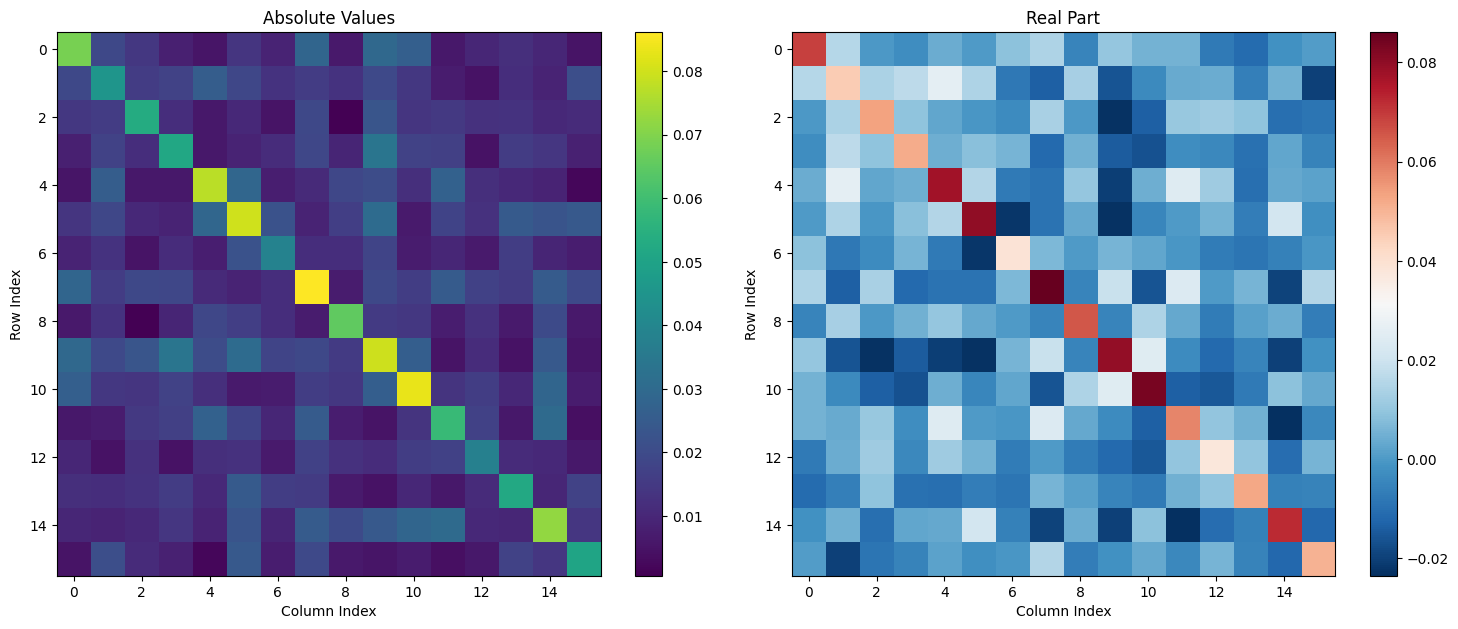

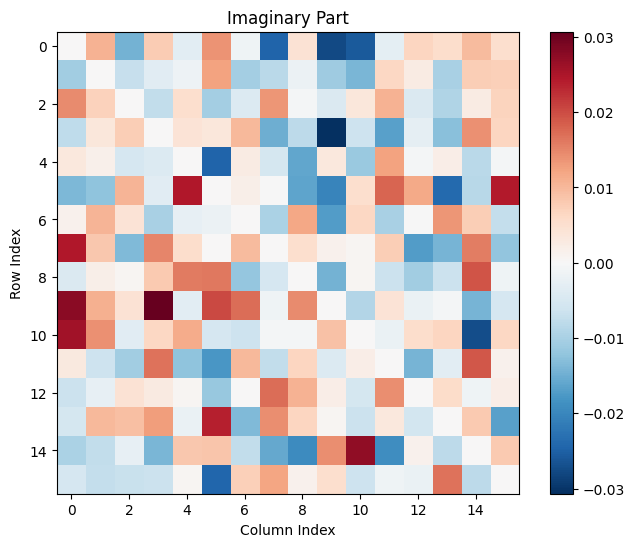

In [60]:
# Get the density matrix as numpy array
rho_matrix = rho_ls.full()

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot absolute values
im1 = ax1.imshow(np.abs(rho_matrix), cmap='viridis')
ax1.set_title('Absolute Values')
ax1.set_xlabel('Column Index')
ax1.set_ylabel('Row Index')
plt.colorbar(im1, ax=ax1)

# Plot real and imaginary parts
im2 = ax2.imshow(np.real(rho_matrix), cmap='RdBu_r')
ax2.set_title('Real Part')
ax2.set_xlabel('Column Index')
ax2.set_ylabel('Row Index')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

# Create another figure for imaginary part
plt.figure(figsize=(8, 6))
im3 = plt.imshow(np.imag(rho_matrix), cmap='RdBu_r')
plt.title('Imaginary Part')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar(im3)
plt.show()